In [1]:
import sys
sys.path.insert(0, '../')
import fconcrete as fc
import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (25,10)

In [2]:
def concrete_beam_function(width, height, length):
    
    n1 = fc.Node.SimpleSupport(x=0, length=20)
    n2 = fc.Node.SimpleSupport(x=length, length=20)

    slab_area = 5*5
    kn_per_m2 = 5
    distributed_load = -slab_area*kn_per_m2/500
    f1 = fc.Load.UniformDistributedLoad(-distributed_load, x_begin=0, x_end=length)
    pp = fc.Load.UniformDistributedLoad(width*height*25/100000, x_begin=0, x_end=length)

    beam = fc.ConcreteBeam(
        loads = [f1, pp],
        nodes = [n1, n2],
        section = fc.Rectangle(width,height),
        bar_steel_max_removal = 100,
        transversal_bar_inclination_angle=90,
        available_long_steel_bars = fc.AvailableLongConcreteSteelBar(diameters=[8], max_number=500),
        available_transv_steel_bars = fc.AvailableTransvConcreteSteelBar(diameters=[6.3], space_is_multiple_of=[1]),
        available_concrete = fc.AvailableConcrete(fck=30, aggressiveness=2),
        solve_transv_steel = True,
        solve_long_steel = True,
        solve_ELS = True,
        solve_cost = True,
        verbose = False,
    )
    
    return beam

In [3]:
beam = concrete_beam_function(15, 30, 200)
self = beam

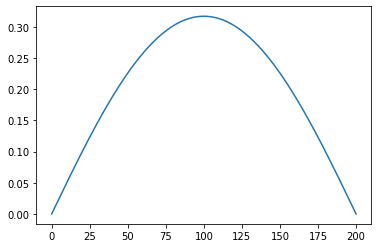

In [4]:
self.plotDisplacementDiagram()

In [32]:
self = beam.copy()

while True:
    x_changes = np.concatenate((self.long_steel_bars.long_begins, self.long_steel_bars.long_ends))
    x_changes = x_changes[np.isin(x_changes, self.beam_elements.nodes.x, invert=True)]
    x_changes = np.unique(x_changes[(x_changes>=0) & (x_changes<=self.length)])

    nodes_change = [ fc.Node.Crimp(x) for x in x_changes ]
    new_nodes = fc.Nodes(np.concatenate((nodes_change, self.beam_elements.nodes)))
    new_nodes = new_nodes[np.argsort(new_nodes.x)]

    previous_ds, diff = 0, 0
    beam_elements = []

    for i in range(0, len(new_nodes)-1):
        current_x = new_nodes[i].x
        next_x = new_nodes[i+1].x
        middle_x = (current_x+next_x)/2

        transversal_position = self.long_steel_bars.getBarTransversalPosition(self, x=middle_x)
        _, beam_element = self.getBeamElementInX(middle_x)
        section, material = beam_element.section, beam_element.material
        height = section.height
        
        _, y, _, area = transversal_position.T
        
        y_positive = y[y >= height/2]
        y_negative = y[y < height/2]
        
        y_c_negative = (y[y >= (height/2)] @ area[y >= (height/2)])/sum(area[y >= (height/2)]) if sum(y >= (height/2)) else np.nan
        y_c_positive = (y[y < (height/2)] @ area[y < (height/2)])/sum(area[y < (height/2)]) if sum(y < (height/2)) else np.nan
        new_positive_steel_height, previous_positive_steel_height = (height - y_c_positive), section.positive_steel_height
        new_negative_steel_height, previous_negative_steel_height = (y_c_negative), section.negative_steel_height
        
        previous_ds += 0 if np.isnan(new_positive_steel_height) else previous_positive_steel_height
        previous_ds += 0 if np.isnan(new_negative_steel_height) else previous_negative_steel_height
        diff += abs(0 if np.isnan(new_positive_steel_height) else previous_positive_steel_height-new_positive_steel_height)
        diff += abs(0 if np.isnan(new_negative_steel_height) else previous_negative_steel_height-new_negative_steel_height)

        new_section = fc.Rectangle(section.width(), section.height)
        
        new_section.positive_steel_height = new_positive_steel_height
        new_section.negative_steel_height = new_negative_steel_height
        new_section.maximum_steel_height = previous_negative_steel_height
        new_section.minimum_steel_height = previous_negative_steel_height
        

        new_beam_element = fc.BeamElement([new_nodes[i], new_nodes[i+1]], new_section, material)
        beam_elements = [*beam_elements, new_beam_element]
    
    break
    relative_diff_of_d = diff/previous_ds
    print(relative_diff_of_d)

    if relative_diff_of_d > self.max_relative_diff_of_steel_height:
        self.beam_elements = fc.BeamElements(beam_elements)
        self.solve_long_steel()
        self.solve_transv_steel()
        self.solve_ELS()
        self.solve_cost()
    else:
        break

In [ ]:
6.570997475485015
24.0
25.369999999999997 24.0
100.0
24.0
24.77 24.0
193.429002524515
24.0
25.369999999999997 24.0

0.009596161535385813


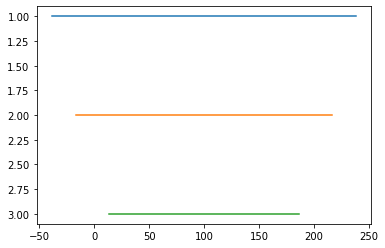

In [144]:
self.long_steel_bars.plot()

In [ ]:
fc.BeamElement()

In [ ]:
beam_elements = fc.BeamElements([])

In [20]:
previous_d, new_d

(24.77, 24.77)

In [26]:
diff/previous_ds

0.015788394504818528

In [16]:
diff

0.0

In [15]:
previous_ds

49.54

In [11]:
beam_element.section.height*.8

24.0

In [27]:
for beam_element in self.beam_elements:
    print(beam_element.section.d)

24.77
24.77
24.77


In [157]:
self.beam_elements

{'bar_elements': array([{'section': <fconcrete.Structural.Section.Rectangle object at 0x12722ffd0>, 'material': <fconcrete.StructuralConcrete.Concrete.Concrete object at 0x127248160>, 'x': [{'x': 0.0, 'condition_boundary': [0, 1], 'length': 20.0}
, {'x': 13.14199495097003, 'condition_boundary': [1, 1], 'length': 0.0}
], 'E': 26838.405317753142, 'I': 33750.0, 'n1': {'x': 0.0, 'condition_boundary': [0, 1], 'length': 20.0}
, 'n2': {'x': 13.14199495097003, 'condition_boundary': [1, 1], 'length': 0.0}
, 'length': 13.14199495097003, 'flexural_rigidity': 905796179.4741685},
       {'section': <fconcrete.Structural.Section.Rectangle object at 0x12722ffd0>, 'material': <fconcrete.StructuralConcrete.Concrete.Concrete object at 0x127248160>, 'x': [{'x': 13.14199495097003, 'condition_boundary': [1, 1], 'length': 0.0}
, {'x': 186.85800504902997, 'condition_boundary': [1, 1], 'length': 0.0}
], 'E': 26838.405317753142, 'I': 33750.0, 'n1': {'x': 13.14199495097003, 'condition_boundary': [1, 1], 'length

In [121]:
middle_x

201.5667128868678

In [ ]:
beam_elements = []
nodes = self.beam_elements.nodes
for beam_element, i in zip(self.beam_elements, range(0,len(self.beam_elements)):
    beam_elements = 
    n1, n2 = self.beam_elements.nodes[i], self.beam_elements.nodes[i+1]
                           
    
    section, material = beam_element.section, beam_element.material
                           
    transversal_position = positive_bars.getBarTransversalPosition(self, x=(current_x+next_x)/2)
    _, y, _, area = transversal_position.T
    y_c = (y @ area)/sum(area)
    section.d = section.height - y_c
                           
    section.d =                  
    beam_elements = [*beam_elements, fc.BeamElement([n1, n2], section, material)]

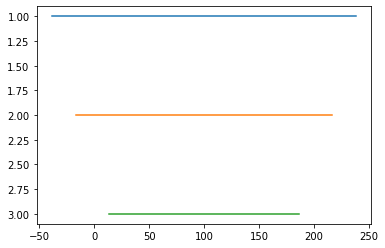

In [151]:
self.long_steel_bars.plot()

In [ ]:
transversal_position = positive_bars.getBarTransversalPosition(self, x=500)
x, y, radius, area = transversal_position.T
x_c = (x @ area)/sum(area) #should be always 0
y_c = (y @ area)/sum(area)